In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import datetime
from scipy import stats
from math import sqrt
import math,os

In [8]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents'

#获取所有path下所有文件
dirs = os.listdir(path)
data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.npy':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = np.load(file)
        data[name]=value
        
#展示录入的所有文件
data.keys()

dict_keys(['AdjFactor', 'BPS', 'BSQ0_TOT_ASSETS', 'CAPQ0_FLOAT_A', 'CAPQ0_FLOAT_A_SHR', 'ClosePrice', 'ClosePrice_index', 'dates', 'EPS_BASIC', 'EPS_dates', 'EPS_ticker_names', 'fd_dates', 'fd_tic', 'FIQ0_S_FA_BPS', 'FIQ0_S_FA_ROE', 'HighestPrice', 'index_ClosePrice', 'index_ticker_names', 'l2_dates', 'l2_ticker_names', 'LowestPrice', 'OpenPrice', 'PRC', 'S_LI_INITIATIVEBUYRATE', 'S_LI_INITIATIVESELLRATE', 'ticker_names', 'ticker_names_index', 'ticker_names_wind', 'TradeStatus', 'TradingDays', 'Turnover', 'Volume', 'VWAP', 'WIND_IDX_INDCLS2_MEMBER', 'WIND_INDCLS_MEMBER'])

In [178]:
#录入path路径下所有的'.npy'结尾的文件
path = 'C:/Users/Administrator/Documents/COP'

#获取所有path下所有文件
dirs = os.listdir(path)
cop_data = {}
#开始录入
for x in dirs:
    #如果以.npy结尾则录入
    if os.path.splitext(x)[1]=='.xlsx':
        name = os.path.splitext(x)[0]
        file = path+'\\'+x
        value = pd.read_excel(file)
        cop_data[name]=value
        
#展示录入的所有文件
cop_data.keys()

dict_keys(['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory', 'operating_income', 'other_expense', 'prepaid', 'R_D_expense'])

In [179]:
for i in cop_data.keys():
    cop_data[i]['证券代码'] = cop_data[i]['证券代码'].apply(lambda x: x[:6])
    cop_data[i].index = cop_data[i]['证券代码'].values
    cop_data[i].drop(['证券简称','证券代码'],axis=1,inplace=True)
    cop_data[i].columns = list(range(2000,2021))
    cop_data[i] = cop_data[i].T

In [180]:
for i in  ['account_payables', 'account_receivables', 'deferred_revenue_current', 'deferred_revenue_noncurrent', 'inventory',
           'other_expense', 'prepaid',]:
    cop_data[i].iloc[:,:] = np.diff(cop_data[i],1,axis=0,prepend=np.nan)
    cop_data[i].fillna(0,inplace=True)
cop_data['R_D_expense'].fillna(0,inplace=True)

In [303]:
#获取因子CVD的原始数据cashvol
#首先读取index 和 colume
tic = data['ticker_names']
dates = pd.to_datetime(data['dates'])
fd_dates = pd.to_datetime(data['fd_dates'])
fd_tick = data['fd_tic']

#统一tic universe
tics = (set(fd_tick)&set(cop_data['operating_income'].columns)&set(tic))

#读取和fama模型相关的市值，BP，ROE，资产回报率
ClosePrice = pd.DataFrame(data['ClosePrice'],index = tic,columns=dates).T[tics]
MarketCap = pd.DataFrame(data['CAPQ0_FLOAT_A'],index = tic,columns=dates).T[tics]
BPS = pd.DataFrame(data['FIQ0_S_FA_BPS'].T,index = fd_dates,columns=fd_tick)[tics]
TotalAsset = pd.DataFrame(data['BSQ0_TOT_ASSETS'].T,index = fd_dates,columns=fd_tick)[tics]
ROE = pd.DataFrame(data['FIQ0_S_FA_ROE'].T,index = fd_dates,columns=fd_tick)[tics]


In [304]:
#对fama5因子相关数据进行数据处理，获得SMB HML RMW CMA的原始对应数据
TotalAsset = TotalAsset.resample('Q').last()
ROE = ROE.resample('Q').last()
BPS = BPS.resample('Q').last()
MC = MarketCap.resample('Q').last()


In [305]:
TotalAsset = TotalAsset.resample('Q').last()
def june_data(df):
    for i in df.index:
        if i.month != 6:
            df.drop(i,axis=0,inplace=True)
    return(df)

TotalAsset = june_data(TotalAsset)
ROE = june_data(ROE)
BPS = june_data(BPS)
MC = june_data(MC)
AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))
AR[abs(AR)==np.inf]=np.nan

<ipython-input-305-b4afe9b1170e>:12: RuntimeWarning: divide by zero encountered in log
  AR = np.log(TotalAsset)-np.log(TotalAsset.shift(1))


In [306]:
#获取COP因子值：
non_scaled = (cop_data['operating_income']+cop_data['R_D_expense']-cop_data['account_receivables']-cop_data['inventory']-cop_data['prepaid']+cop_data['deferred_revenue_current']+cop_data['deferred_revenue_noncurrent']+cop_data['account_payables']+cop_data['other_expense'])[tics]
non_scaled.index = TotalAsset.index[9:-1]
COP = non_scaled / TotalAsset.loc[non_scaled.index,tics]
COP[abs(COP)==np.inf] = np.nan

#去除极端值

COP.tail()

003033    688160    603606    300278    002330    600439  \
2016-06-30  0.123794  0.148165  0.022061 -0.046776  0.015192  0.090701   
2017-06-30  0.228186  0.301636 -0.202164 -0.065883 -0.018712  0.040645   
2018-06-30  0.251153  0.321572  0.099975  0.064998 -0.027334 -0.041856   
2019-06-30  0.318764  0.380250  0.114728 -0.071959  0.016176  0.032556   
2020-06-30  0.237294  0.668689  0.104047 -0.069639  0.033845  0.042219   

              300017    002076    300080    002590  ...    000042    600030  \
2016-06-30  0.113916 -0.026517 -0.036055  0.032934  ... -0.076925  0.024294   
2017-06-30  0.113220 -0.272613 -0.074618  0.039127  ... -0.202052  0.026015   
2018-06-30  0.113339 -0.168884  0.147826  0.013990  ...  0.079363  0.018245   
2019-06-30  0.055012  0.078806  0.168564  0.104305  ... -0.078040  0.025263   
2020-06-30  0.073959  0.005681  0.061417  0.062218  ...  0.057485  0.022376   

              601700    300558  300919    600495    002189    002893  \
2016-06-30 -0.019039  1.590626     NaN -0.009218  0.015888  0.038171   
2017-06-30  0.083701  0.107778     NaN  0.062174  0.092596  0.069102   
2018-06-30  0.009944  0.200532     NaN  0.063569  0.016897  0.074351   
2019-06-30 -0.085415  0.128198     NaN  0.083834  0.101376  0.060047   
2020-06-30  0.158219  0.231353     NaN  0.030316  0.042498  0.024645   

              600990    000581  
2016-06-30  0.070431  0.100955  
2017-06-30 -0.061780  0.153197  
2018-06-30  0.057245  0.121780  
2019-06-30  0.016863  0.119866  
2020-06-30 -0.064669  0.148510  

[5 rows x 4232 columns]

In [307]:
#对数据进行中心化和标准化处理，去除极端值，且不改变每期的大小排序
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)

COP = normalization(COP,ax=0)
COP.tail()

003033    688160    603606    300278    002330    600439  \
2016-06-30 -1.413831 -1.210188 -0.036409  0.085374  0.109890  1.440914   
2017-06-30 -0.202443 -0.304864 -1.842809 -0.244360 -1.048241  0.687893   
2018-06-30  0.259817 -0.187262  0.657294  1.404311 -1.342775 -0.553210   
2019-06-30  1.375582  0.158878  0.788643 -0.349208  0.143534  0.566209   
2020-06-30 -0.019125  1.543436  0.693543 -0.309180  0.747080  0.711581   

              300017    002076    300080    002590  ...    000042    600030  \
2016-06-30 -0.203580 -0.207034  0.030356 -0.222069  ... -0.267573 -0.765442   
2017-06-30 -0.210756 -1.686890 -0.229831  0.025945  ... -1.044550 -0.710614   
2018-06-30 -0.209530 -1.686890  1.271042 -0.980774  ...  0.702892 -0.958239   
2019-06-30 -0.811722  1.252285  1.410968  2.341665  ... -0.274497 -0.734564   
2020-06-30 -0.616102  0.239083  0.688024  0.950730  ...  0.567041 -0.826572   

              601700    300558  300919    600495    002189    002893  \
2016-06-30 -0.490776  1.062226     NaN -0.398976  0.051418 -0.713756   
2017-06-30  0.866369 -0.957931     NaN  0.575631  1.601283  0.749097   
2018-06-30 -0.107924 -0.705212     NaN  0.594665  0.071802  0.997299   
2019-06-30 -1.367568 -0.902295     NaN  0.871323  1.778689  0.320827   
2020-06-30  1.850719 -0.621238     NaN  0.140726  0.589062 -1.353466   

              600990    000581  
2016-06-30  0.802087 -0.167040  
2017-06-30 -0.741039  1.180838  
2018-06-30  0.648187  0.370264  
2019-06-30  0.176858  0.320877  
2020-06-30 -0.774758  1.059911  

[5 rows x 4232 columns]

mean                    -4.7274e-18
median                  -0.00805475
max                         3.32154
min                        -3.41024
std                        0.957102
skewness     [0.025678435128306237]
kurtosis    [-0.035507991051956456]
dtype: object


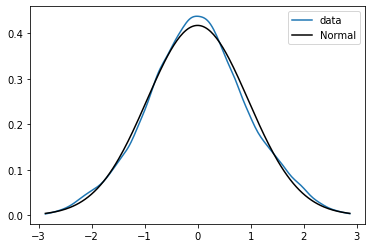

In [308]:
#描述性统计量(对观察期内全部样本数据)
def statistics(close):
    
    mc = np.mean(close)
    stdc = np.std(close)
    print(pd.Series({'mean':mc,'median':np.median(close),'max':np.max(close),'min':np.min(close),'std':stdc,'skewness':stats.skew(close.T),'kurtosis':stats.kurtosis(close.T)}))
    
    #distribution plot
    x = np.linspace(mc-3*stdc,mc+3*stdc,200)
    y = stats.norm.pdf(x,mc,stdc)
    kde = stats.gaussian_kde(close)
    plt.plot(x,kde(x),label='data')
    plt.plot(x,y,color='black',label='Normal')
    plt.legend()
    plt.show()
    
statistics(np.hstack([COP.loc[k,:].dropna().values.reshape(1,-1) for k in COP.index]))

In [309]:
#取log return
ClosePrice = ClosePrice.resample('Q').last()
ClosePrice = june_data(ClosePrice)
Re = np.log(ClosePrice.shift(-1)) - np.log(ClosePrice)
Re.tail()

003033  688160    603606    300278    002330    600439    300017  \
2017-06-30     NaN     NaN -0.174579 -0.603828 -0.507430 -0.421282 -0.116949   
2018-06-30     NaN     NaN  0.424606 -0.438531  0.076336 -0.167768  0.008839   
2019-06-30     NaN     NaN  0.526310 -0.502315  0.224541 -0.058922 -0.234945   
2020-06-30     NaN     NaN  0.466386 -0.113555 -0.214106 -0.138444 -0.279471   
2021-06-30     NaN     NaN       NaN       NaN       NaN       NaN       NaN   

              002076    300080    002590  ...    000042    600030    601700  \
2017-06-30 -0.410428 -0.462321 -0.531186  ... -0.100599 -0.006188 -0.548823   
2018-06-30 -0.407600  0.202524 -0.018462  ... -0.391041  0.387389  0.612624   
2019-06-30 -0.163273 -0.287682 -0.153195  ...  0.013007  0.027909 -0.138273   
2020-06-30 -0.256720 -0.006689 -0.076256  ... -0.121454  0.016588 -0.077037   
2021-06-30       NaN       NaN       NaN  ...       NaN       NaN       NaN   

              300558  300919    600495    002189    002893    600990    000581  
2017-06-30 -0.066523     NaN -0.607555 -0.242340       NaN -0.226168 -0.134965  
2018-06-30 -0.291120     NaN  0.215320  0.554910 -0.250816 -0.054607 -0.057599  
2019-06-30  1.217611     NaN -0.210565 -0.271686 -0.172875 -0.158531  0.159427  
2020-06-30 -0.314079     NaN  0.027733 -0.034922  0.114776  0.136083  0.140519  
2021-06-30       NaN     NaN       NaN       NaN       NaN       NaN       NaN  

[5 rows x 4232 columns]

In [310]:
#获取上证指数年度return
market_index = pd.DataFrame(data['index_ClosePrice'],index=data['index_ticker_names'],columns=pd.to_datetime(data['EPS_dates'])).T['000001']
market_index = market_index.resample('Q').last()
market_index = june_data(market_index)
market_index_return = np.log(market_index.shift(-1))-np.log(market_index)
market_index_return.tail()

2017-06-30   -0.114369
2018-06-30    0.045134
2019-06-30    0.001944
2020-06-30    0.142320
2021-06-30         NaN
Name: 000001, dtype: float64

In [311]:
#获取SMB HML RMW CMA各组收益
smb = []
hml = []
rmw = []
cma = []

ob_d = COP.index

def fama_groups(df,g=3):
    label = list(range(g))
    fama_sort = pd.qcut(df.dropna(),g,labels=label)

    big = fama_sort[fama_sort==label[-1]].index
    small = fama_sort[fama_sort==label[0]].index
    return(big,small)

for i in ob_d:
    h,l = fama_groups(MC.loc[i,:])
    b,s = fama_groups(BPS.loc[i,:])
    w,r = fama_groups(ROE.loc[i,:])
    c,a = fama_groups(TotalAsset.loc[i,:],2)
    
    hml.append(Re.loc[i,h].mean()-Re.loc[i,l].mean())
    smb.append(Re.loc[i,s].mean()-Re.loc[i,b].mean())
    rmw.append(Re.loc[i,r].mean()-Re.loc[i,w].mean())
    cma.append(Re.loc[i,c].mean()-Re.loc[i,a].mean())
    
hml = pd.Series(hml,index=ob_d)
smb = pd.Series(smb,index=ob_d)
rmw = pd.Series(rmw,index=ob_d)
cma = pd.Series(cma,index=ob_d)

In [389]:
#去除金融行业的数据 #882115 882116 882117
#获取wind行业分类
ind = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'],index=tic,columns=dates).T[tics]
ind= ind.resample('y').last()
for i in tics:
    for j in ind.index:
        ind.loc[j,i] = ind.loc[j,i] in ['882115', '882116', '882117']
ind

KeyboardInterrupt: 

In [386]:
#创建分析类
class factor_analysis(object):
    def __init__(self, factors):
        self.factors = factors
    
    #等值加权
    def E_weight(self,ob_t,tt='cvd'):
        ew_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))
        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(10)))
            ew_re.loc[i,:] = self.Re.loc[i,groups.index].groupby(by=groups).mean()

        #多空组合
        ew_re['h-l'] = ew_re[9]-ew_re[0]
        
        #cumulative return
        ew_re_cum = ew_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in range(10):
            plt.plot(ew_re[i],label='group'+str(i))
        plt.plot(ew_re['h-l'],label='group h-l')
        plt.title('equal_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(10):
            plt.plot(ew_re_cum[i],label='group'+str(i))
        plt.plot(ew_re_cum['h-l'],label='group h-l')
        plt.title('equal_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(ew_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))
        return(ew_re.apply(evaluate,axis=0).T)
    
    #市值加权
    def MC_weight(self,ob_t,tt='cvd'):
        mw_re = pd.DataFrame(None,index=ob_t,columns=list(range(10)))

        #收益率乘以市值再分组加总后，除以各组市值加总即为各组市值加权平均收益，这一方法在迭代上具有优势
        mw = self.Re*self.MarketCap

        for i in self.factors.index:
            selected = self.Re.loc[i,:].dropna().index
            groups = pd.qcut(self.factors.loc[i,selected],10,labels=list(range(10)))
            mw_re.loc[i,:] = mw.loc[i,groups.index].groupby(by=groups).sum()/self.MarketCap.loc[i,groups.index].groupby(by=groups).sum()

        #多空组合
        mw_re['h-l'] = mw_re[9]-mw_re[0]
        
        #cumulative return
        mw_re_cum = mw_re.cumsum()

        #plot
        plt.figure(figsize=(20,24))
        plt.subplot(211)
        for i in range(10):
            plt.plot(mw_re[i],label='group'+str(i))
        plt.plot(mw_re['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_log_return_'+tt)
        plt.legend()

        plt.subplot(212)
        for i in range(10):
            plt.plot(mw_re_cum[i],label='group'+str(i))
        plt.plot(mw_re_cum['h-l'],label='group h-l')
        plt.title('MarketCap_weighted_cumulative_log_return_'+tt)
        plt.legend()
        
        m = np.exp(mw_re_cum.iloc[-1,:].mean())
        def evaluate(df1,rf=0.0384,n=20):
            df1 = df1.astype('float')
            
            #CAPM
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            capm_alpha = beta[0][0,0]
            capm_beta = beta[1][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_capm = beta.T/se
            
            #fama 3-factor
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama3_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama3 = beta.T/se
            
            #fama 5-factor
            
            X = np.mat(np.stack([np.ones(market_index_return[ob_t].shape),market_index_return[ob_t],hml[ob_t],smb[ob_t],rmw[ob_t],cma[ob_t]]).T).astype('float')
            y = np.mat(df1).T
            beta = (X.T*X).I*X.T*y
            fama5_alpha = beta[0][0,0]
            u = y-X*beta
            
            #estimated variation of regression
            varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
            se = np.sqrt(np.diag(varbeta))
            t_value_fama5 = beta.T/se
            
            df = df1.cumsum()
            df = np.exp(df.astype('float'))
            Maxdrawdown = -round(((df-df.expanding().max())/df.expanding().max()).min(),3)
            alpha = (df[-1]-m)/n
            sr = round((df[-1]-1-rf*n)/(df.std()*12**0.5),3)
            return(pd.Series({'TotalReturn':round(df[-1]-1,4),'AnnualReturn':round(df[-1]**(1/n)-1,4),'Sharpe':sr,
                              'CAPM Alpha':[round(capm_alpha,4),round(t_value_capm[0,0],4)],'Beta':[round(capm_beta,4),round(t_value_capm[0,1],4)]
                              ,'fama-3-factor alpha':[round(fama3_alpha,4),round(t_value_fama3[0,0],4)]
                              ,'fama-5-factor alpha':[round(fama5_alpha,4),round(t_value_fama5[0,0],4)],'Maxdrawdown':Maxdrawdown}))

        return(mw_re.apply(evaluate,axis=0).T)


TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.2005       0.0092  -0.23  [-0.0213, -0.6276]    [1.0861, 9.9421]   
1        0.3818       0.0163 -0.184   [-0.0134, -0.432]   [1.0446, 10.4305]   
2        0.9097       0.0329  0.047    [0.0023, 0.0753]   [1.0326, 10.3729]   
3         0.682       0.0263 -0.038  [-0.0046, -0.1445]   [1.0632, 10.4343]   
4        0.7234       0.0276 -0.018  [-0.0037, -0.1155]   [1.0735, 10.4072]   
5        0.8866       0.0322  0.044    [0.0017, 0.0569]   [1.0343, 10.7484]   
6        1.5973       0.0489  0.241    [0.0168, 0.5465]   [1.0401, 10.5164]   
7        1.9414       0.0554  0.301    [0.0227, 0.7624]   [1.0395, 10.8262]   
8        1.6744       0.0504   0.27    [0.0187, 0.6754]   [1.0212, 11.4517]   
9        2.8117       0.0692  0.432    [0.0362, 1.3388]   [0.9963, 11.4148]   
h-l      2.1751       0.0595  0.744    [0.0575, 3.4279]  [-0.0897, -1.6587]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0883, -3.4973]  [-0.0512, -1.6001]       0.721  
1    [-0.0822, -3.3627]   [-0.037, -1.2741]       0.723  
2    [-0.0577, -2.3401]  [-0.0053, -0.1951]       0.682  
3     [-0.0687, -2.813]   [-0.0232, -0.812]       0.739  
4    [-0.0627, -2.5322]  [-0.0159, -0.5475]       0.725  
5    [-0.0515, -2.0226]    [0.0053, 0.1923]       0.696  
6    [-0.0424, -1.8532]    [0.0054, 0.2108]       0.716  
7    [-0.0341, -1.3802]    [0.0081, 0.2698]       0.669  
8    [-0.0442, -2.1926]    [0.0024, 0.1127]       0.666  
9    [-0.0208, -0.7868]     [0.026, 0.8474]       0.596  
h-l    [0.0675, 3.8638]    [0.0772, 3.3062]       0.073

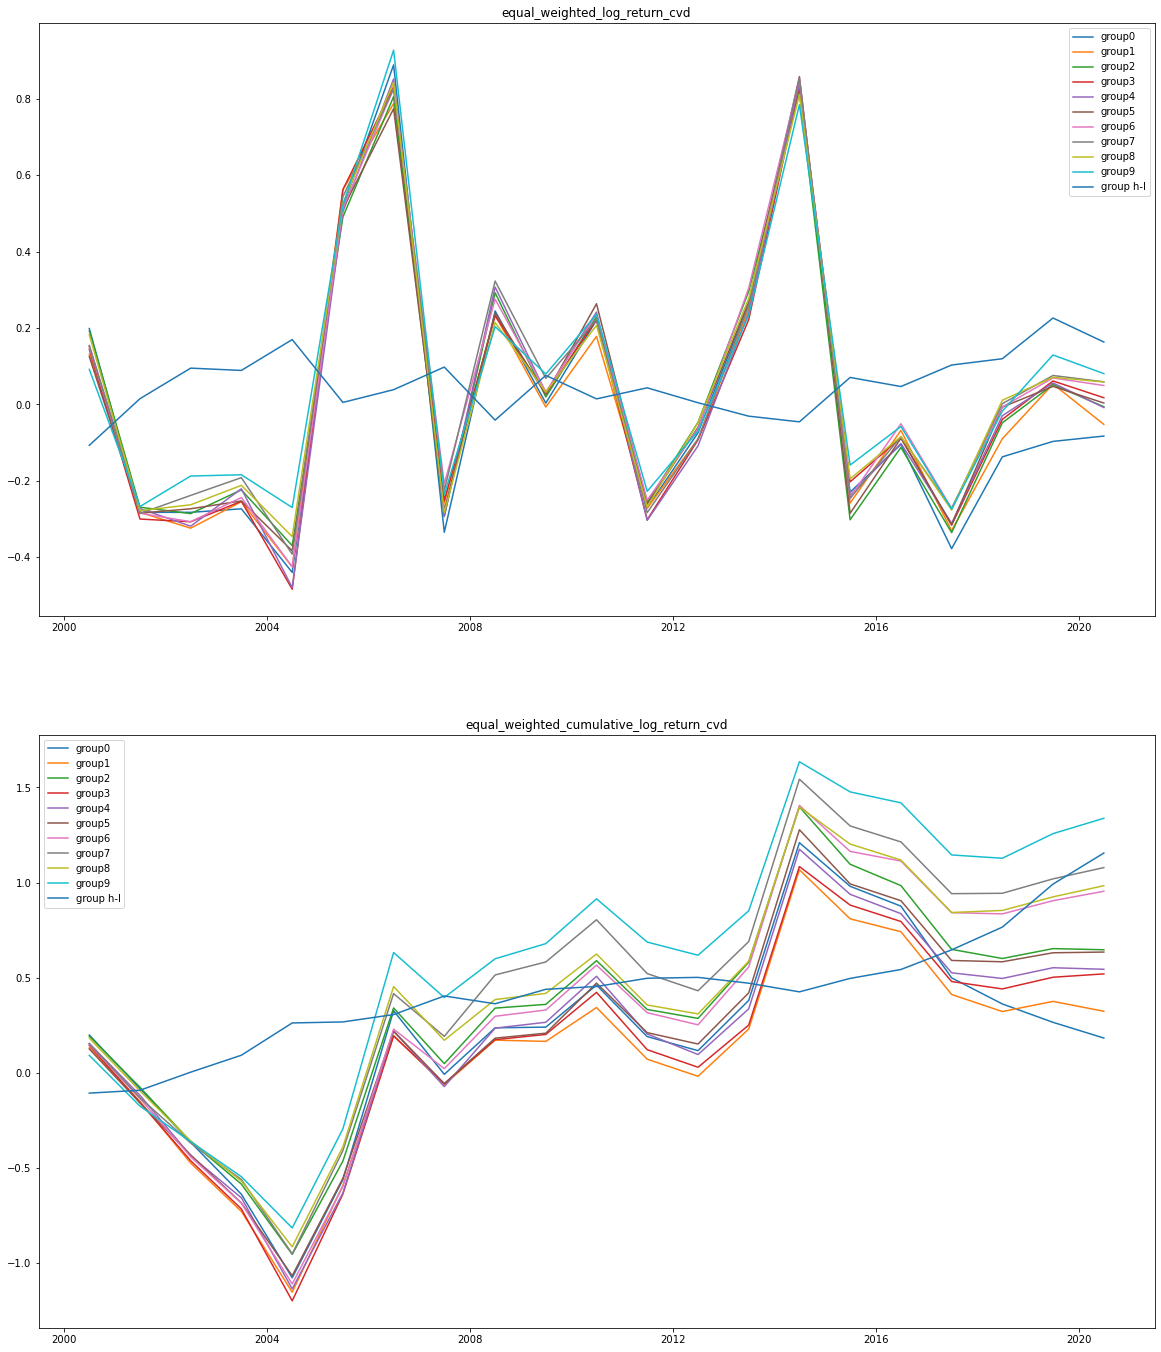

In [387]:
#传入参数
cvd_ana = factor_analysis(COP)
cvd_ana.Re = Re
cvd_ana.MarketCap = MC

#等值加权
cvd_ana.E_weight(ob_t = COP.index,tt='cvd')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.2546      -0.0146 -0.936  [-0.0456, -2.4076]   [1.1446, 18.7531]   
1       -0.0428      -0.0022  -0.89   [-0.0324, -2.593]   [1.1002, 27.2745]   
2         0.336       0.0146 -0.283  [-0.0169, -1.0652]   [1.1122, 21.7526]   
3        0.1329       0.0063 -0.586  [-0.0239, -1.1218]   [1.0803, 15.7485]   
4        0.1371       0.0064 -0.601  [-0.0242, -1.4055]   [1.0987, 19.7945]   
5        0.3128       0.0137 -0.435  [-0.0156, -1.1493]   [1.0355, 23.6475]   
6        1.1628       0.0393  0.215    [0.0083, 0.4008]   [1.0312, 15.4572]   
7         0.598       0.0237 -0.125  [-0.0056, -0.3791]    [1.013, 21.1759]   
8        0.4589       0.0191 -0.245  [-0.0097, -0.6743]   [1.0044, 21.5978]   
9        0.8457       0.0311  0.049    [0.0037, 0.1634]   [0.9246, 12.7356]   
h-l       1.476       0.0464  0.544    [0.0492, 2.1454]  [-0.2199, -2.9712]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0638, -2.7642]  [-0.0362, -1.1971]        0.69  
1    [-0.0406, -2.5821]  [-0.0265, -1.2582]        0.67  
2    [-0.0216, -1.0515]      [0.008, 0.309]        0.64  
3    [-0.0459, -1.6486]  [-0.0169, -0.4594]       0.705  
4    [-0.0373, -1.7914]  [-0.0315, -1.1144]       0.676  
5    [-0.0317, -1.7918]  [-0.0104, -0.4579]       0.619  
6    [-0.0018, -0.0654]     [0.048, 1.4922]       0.683  
7    [-0.0242, -1.3939]    [0.0056, 0.2656]        0.61  
8    [-0.0354, -2.1639]  [-0.0129, -0.6184]       0.633  
9    [-0.0284, -0.9929]    [0.0184, 0.5669]       0.603  
h-l    [0.0354, 1.2178]    [0.0545, 1.5116]       0.259

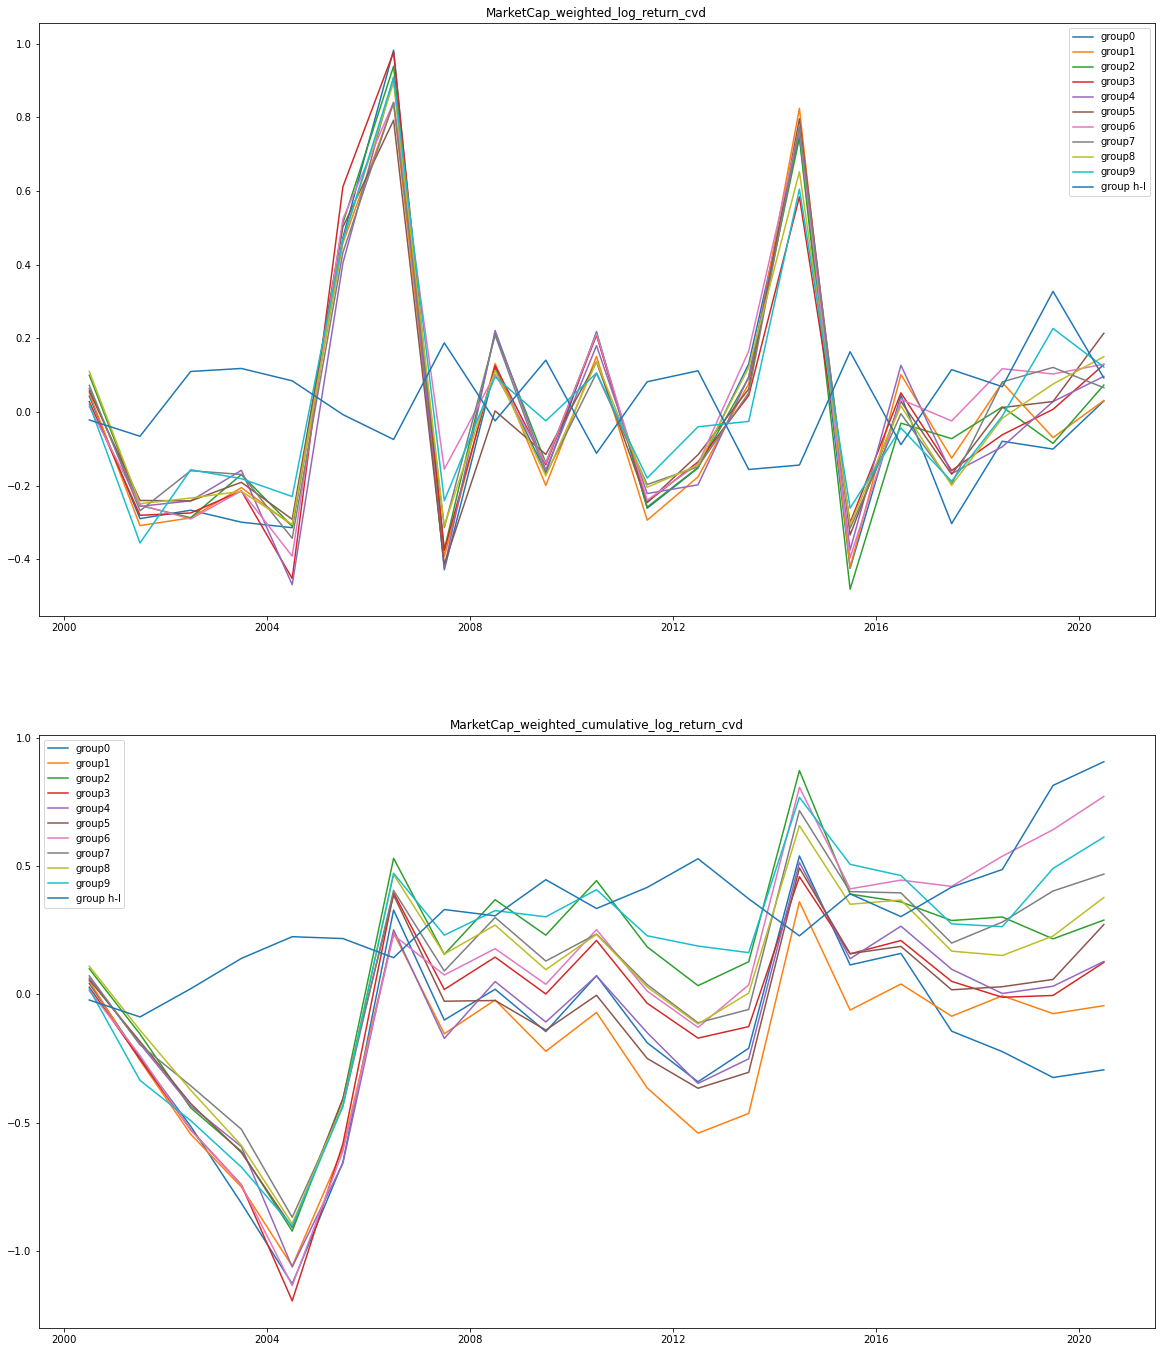

In [388]:
#市值加权
cvd_ana.MC_weight(ob_t = COP.index,tt='cvd')

TotalReturn AnnualReturn Sharpe          CAPM Alpha               Beta  \
0         1.095       0.1942  0.578    [0.0107, 0.7943]   [0.4328, 2.5487]   
1        1.4022       0.2341  0.598    [0.0135, 1.0163]   [0.4314, 2.5857]   
2        1.1266       0.1985  0.573    [0.0111, 0.8247]   [0.4184, 2.4578]   
3        1.4375       0.2384  0.603    [0.0138, 1.0296]   [0.4247, 2.5131]   
4        1.3268       0.2247  0.586    [0.0128, 0.9483]   [0.4294, 2.5171]   
5        1.4955       0.2454  0.593    [0.0145, 1.0885]   [0.4012, 2.3897]   
6        1.1566       0.2026  0.535    [0.0112, 0.8479]   [0.4396, 2.6358]   
7        1.1825        0.206  0.542    [0.0115, 0.8745]   [0.4377, 2.6465]   
8        1.5645       0.2536  0.589    [0.0146, 1.1211]   [0.4471, 2.7219]   
9        1.8253       0.2831  0.556    [0.0158, 1.1939]   [0.5258, 3.1515]   
l-h     -0.2585      -0.0693 -0.988  [-0.0051, -0.9788]  [-0.093, -1.4156]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0079, -0.5071]     [0.0079, 0.493]       0.413  
1     [-0.006, -0.3983]    [0.0106, 0.6912]       0.404  
2    [-0.0076, -0.4871]       [0.01, 0.648]       0.437  
3    [-0.0052, -0.3407]    [0.0129, 0.8482]       0.406  
4    [-0.0047, -0.3015]    [0.0134, 0.8682]       0.425  
5    [-0.0031, -0.2042]     [0.0146, 0.966]       0.423  
6    [-0.0063, -0.4056]    [0.0122, 0.7994]       0.467  
7     [-0.0063, -0.414]    [0.0121, 0.8051]       0.445  
8    [-0.0025, -0.1644]    [0.0147, 0.9539]       0.435  
9    [-0.0056, -0.3646]    [0.0096, 0.6057]       0.466  
l-h  [-0.0023, -0.3622]  [-0.0017, -0.2427]       0.409

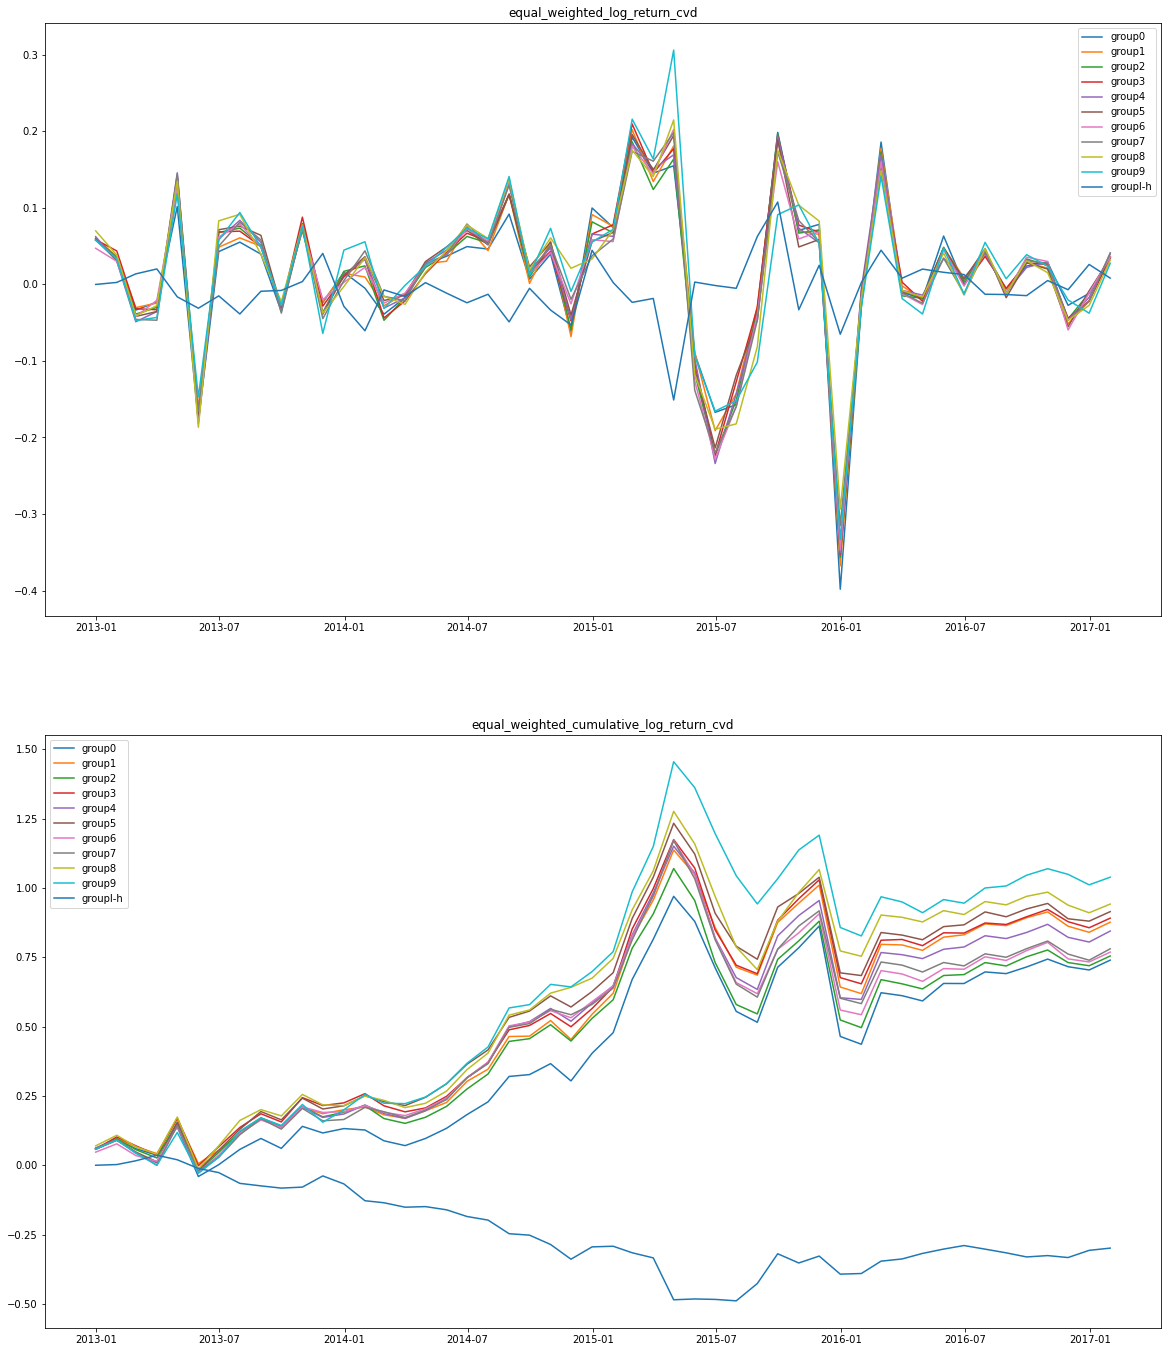

In [78]:
#传入参数
cvd_test = factor_analysis(groups_test)
cvd_test.Re = Re_test
cvd_test.MarketCap = MarketCap_test

#等值加权
cvd_test.E_weight(ob_t = new_obt,tt='cvd')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.3316       0.0711  0.198     [0.002, 0.1666]    [0.3985, 2.6766]   
1        0.4572       0.0946  0.283    [0.0043, 0.3955]    [0.3395, 2.4622]   
2        0.2875       0.0625  0.145    [0.0016, 0.1394]    [0.3705, 2.6262]   
3         0.593       0.1182  0.392    [0.0058, 0.5055]    [0.3767, 2.6242]   
4        0.3837       0.0811  0.234      [0.0031, 0.26]    [0.3652, 2.4701]   
5        0.5001       0.1022  0.251    [0.0049, 0.4049]    [0.3416, 2.2463]   
6        0.4103        0.086  0.214    [0.0027, 0.2222]    [0.4463, 2.9502]   
7        0.7664       0.1463  0.399    [0.0076, 0.6291]    [0.3994, 2.6208]   
8        0.3313       0.0711  0.168    [0.0023, 0.1917]    [0.3654, 2.4406]   
9       -0.0298      -0.0072 -0.132  [-0.0052, -0.3794]    [0.4851, 2.8209]   
l-h      0.3725        0.079   0.29    [0.0071, 0.7691]  [-0.0866, -0.7398]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0011, -0.0759]    [0.0097, 0.6159]       0.441  
1      [0.0028, 0.2106]    [0.0146, 1.0242]        0.38  
2    [-0.0013, -0.0943]    [0.0144, 1.0275]       0.475  
3      [0.0009, 0.0631]    [0.0161, 1.1269]       0.448  
4      [0.0069, 0.4764]    [0.0227, 1.5692]       0.469  
5      [0.0078, 0.5197]    [0.0243, 1.6157]       0.495  
6      [0.0058, 0.3737]    [0.0244, 1.5751]       0.508  
7      [0.0093, 0.6042]    [0.0277, 1.8322]       0.521  
8      [0.0081, 0.5333]     [0.024, 1.5809]       0.472  
9    [-0.0024, -0.1354]    [0.0178, 1.0216]       0.683  
l-h    [0.0013, 0.1176]  [-0.0081, -0.7365]       0.361

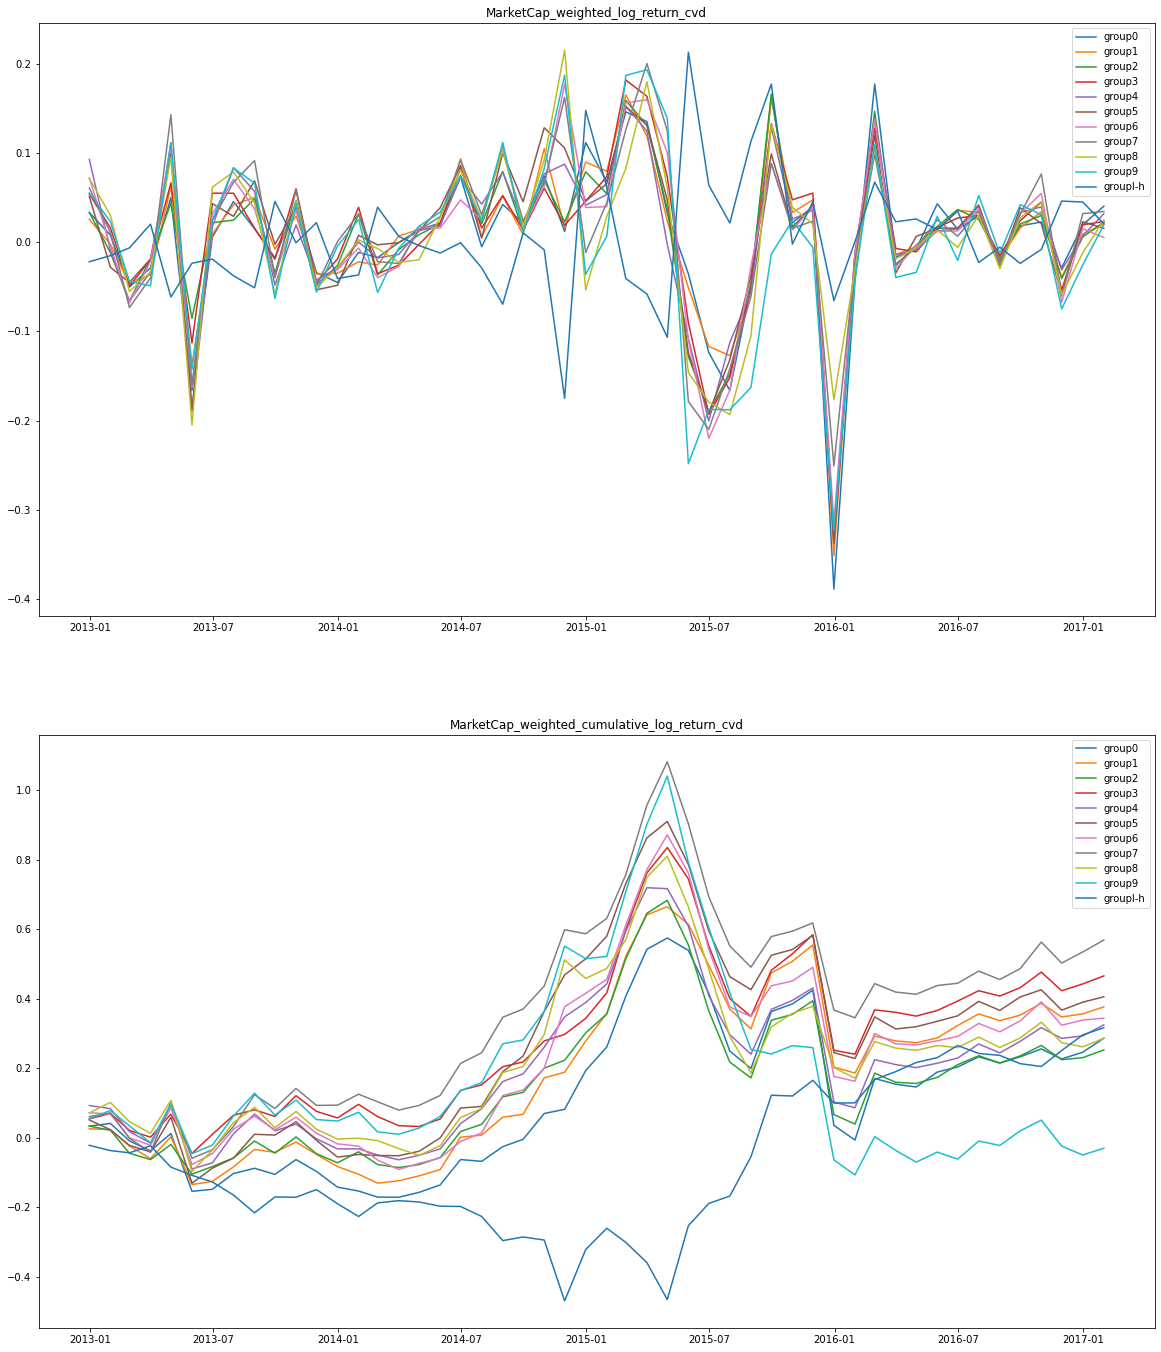

In [79]:
#市值加权
cvd_test.MC_weight(ob_t = new_obt,tt='cvd')

In [80]:
#选取不同行业
industry = pd.DataFrame(data['WIND_IDX_INDCLS2_MEMBER'],index = tic,columns=dates).T

In [42]:
industry.iloc[4000,:].groupby(industry.iloc[4000,:]).count()

2007-04-09 00:00:00
0         2928
882100      34
882101     284
882102     263
882103       7
882104      62
882105      61
882106     105
882107      21
882108       8
882109      66
882110      15
882111      91
882112       7
882113      16
882114      96
882115       8
882116       5
882117       2
882118      97
882119      28
882120      90
882121      10
882122       1
882123      63
Name: 2007-04-09 00:00:00, dtype: int64

In [43]:
industry.loc[ob_t[0],:].value_counts()

0         1250
882102     664
882101     512
882120     247
882106     191
882114     185
882119     181
882111     155
882118     141
882105     125
882123      94
882104      93
882108      75
882100      73
882109      69
882103      61
882113      53
882121      53
882116      44
882107      40
882115      25
882110      21
882112       7
882117       5
882122       4
Name: 2017-02-28 00:00:00, dtype: int64

In [44]:
#我们选取wind行业标码为 882101(材料) 882102(资本货物) 882120（技术硬件与设备)的行业
ind_882101 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882101].index
ind_882102 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882102].index
ind_882120 = industry.loc[ob_t[0]][industry.loc[ob_t[0]]==882120].index

In [45]:
def get_observations_ind(Re,MarketCap,factors,ob_t,tics):    
    #dropna and infs
    factor = factors.loc[ob_t,tics].copy()
    #处理极端数据
    factor[factor>10]=np.NaN
    factor[factor==0]=np.NaN
    factor.dropna(axis=1,inplace=True)
    Re = Re.loc[ob_t,factor.columns]
    MarketCap = MarketCap.resample('M').last().loc[ob_t,factor.columns]
    return(Re,MarketCap,factor)

#数据处理
Re_ind_882101,MarketCap_ind_882101,cvd_ind_882101 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882101)
Re_ind_882102,MarketCap_ind_882102,cvd_ind_882102 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882102)
Re_ind_882120,MarketCap_ind_882120,cvd_ind_882120 = get_observations_ind(Re,MarketCap,cvd,ob_t,ind_882120)
groups_ind_882101 = cvd_ind_882101.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_ind_882102 = cvd_ind_882102.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
groups_ind_882120 = cvd_ind_882120.apply(lambda x: pd.qcut(x,10,labels=list(range(10))),axis=1)
print('start_date ',ob_t[0],'\nend_date ',ob_t[-1])

start_date  2017-02-28 00:00:00 
end_date  2021-03-31 00:00:00


In [46]:
#传入数据
ind_882101_test = factor_analysis(groups_ind_882101)
ind_882101_test.Re = Re_ind_882101
ind_882101_test.MarketCap = MarketCap_ind_882101

ind_882102_test = factor_analysis(groups_ind_882102)
ind_882102_test.Re = Re_ind_882102
ind_882102_test.MarketCap = MarketCap_ind_882102

ind_882120_test = factor_analysis(groups_ind_882120)
ind_882120_test.Re = Re_ind_882120
ind_882120_test.MarketCap = MarketCap_ind_882120


TotalReturn AnnualReturn Sharpe          CAPM Alpha              Beta  \
0        0.2243       0.0498   0.11    [0.0035, 0.3881]  [0.2799, 1.5492]   
1       -0.0677      -0.0167 -0.544  [-0.0018, -0.2238]  [0.1956, 1.2196]   
2       -0.0505      -0.0124  -0.56  [-0.0014, -0.1762]  [0.2069, 1.2557]   
3        0.0001            0 -0.464  [-0.0004, -0.0527]  [0.2208, 1.3321]   
4        -0.141      -0.0358 -0.781   [-0.0034, -0.404]   [0.1819, 1.077]   
5       -0.1709       -0.044 -0.822   [-0.004, -0.4559]  [0.1297, 0.7354]   
6       -0.3375      -0.0941 -1.177  [-0.0086, -0.9613]     [0.1607, 0.9]   
7       -0.3698      -0.1049 -1.227  [-0.0096, -1.1131]   [0.162, 0.9403]   
8       -0.4405      -0.1301 -1.364  [-0.0119, -1.3423]  [0.1288, 0.7256]   
9       -0.5088      -0.1569   -1.2  [-0.0144, -1.6407]  [0.1163, 0.6578]   
l-h      1.4926       0.2451  0.932    [0.0179, 2.9204]  [0.1637, 1.3275]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0078, 0.8146]    [0.0088, 0.8052]       0.423  
1      [0.0044, 0.5297]    [0.0063, 0.6676]       0.415  
2      [0.0051, 0.5974]    [0.0067, 0.6873]       0.392  
3       [0.008, 0.9573]    [0.0095, 1.0064]       0.352  
4      [0.0046, 0.5431]    [0.0082, 0.8512]       0.401  
5      [0.0048, 0.5561]    [0.0088, 0.8971]       0.433  
6      [0.0005, 0.0563]     [0.007, 0.7179]       0.495  
7     [-0.0003, -0.038]    [0.0058, 0.6248]       0.454  
8    [-0.0027, -0.3101]    [0.0027, 0.2839]       0.522  
9    [-0.0063, -0.7134]  [-0.0022, -0.2235]       0.534  
l-h    [0.0141, 2.3505]     [0.011, 1.6563]       0.095

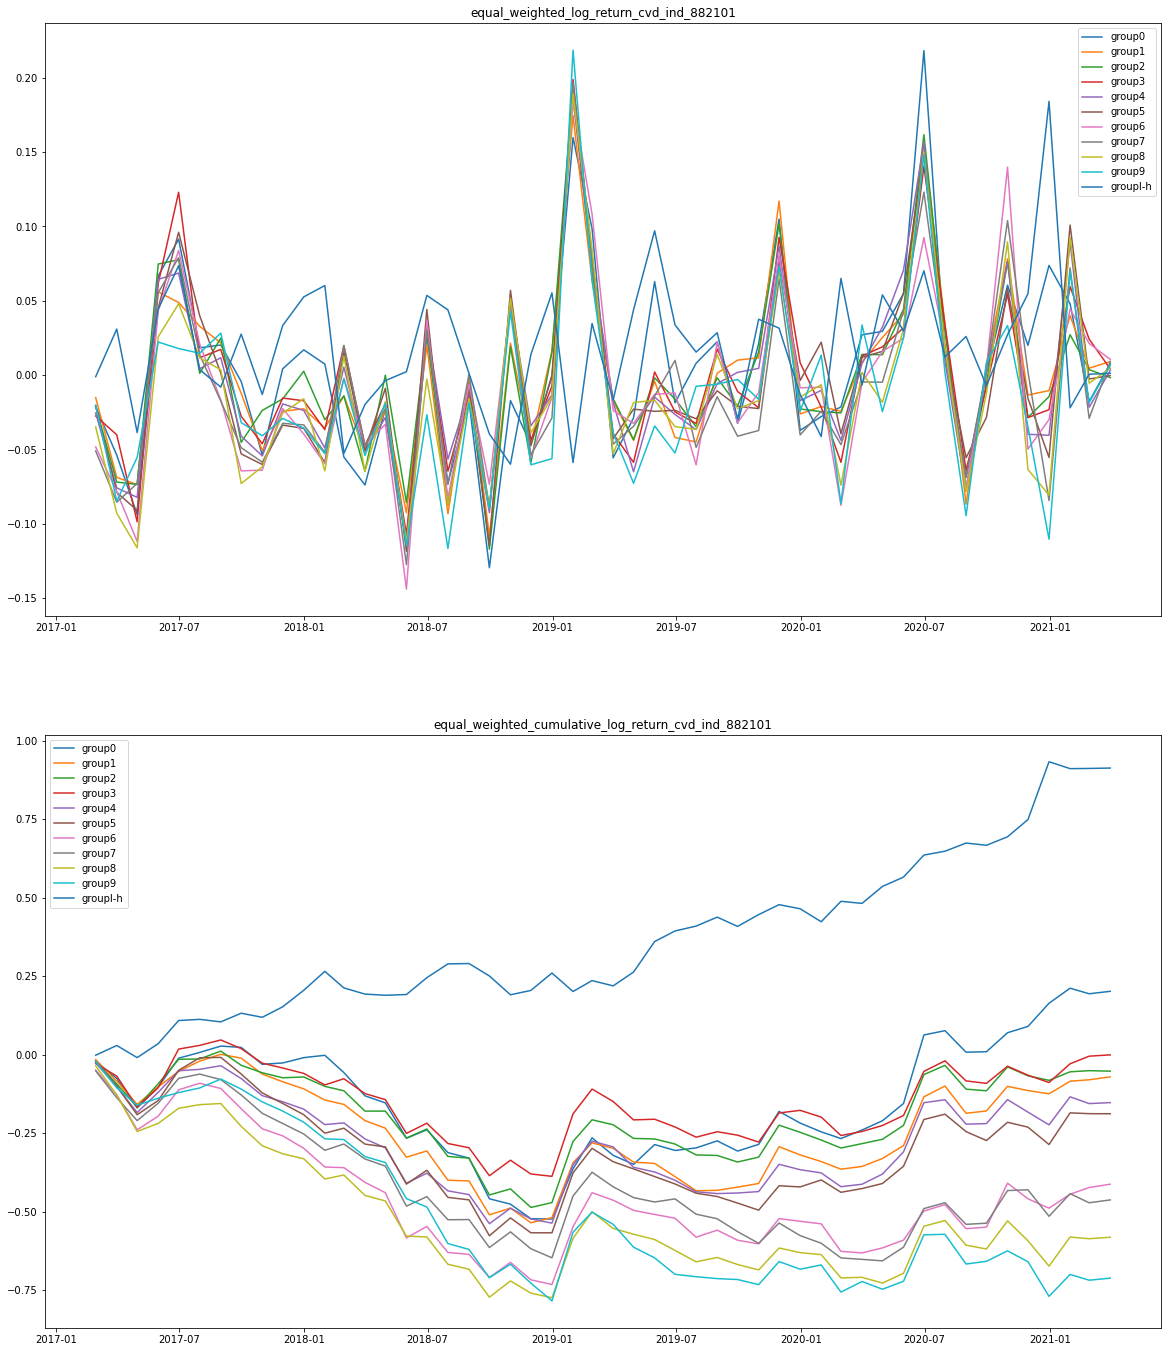

In [47]:
#882101等值加权
ind_882101_test.E_weight(ob_t = ob_t,tt='cvd_ind_882101')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.7929       0.1504  0.726    [0.0114, 1.1543]    [0.1496, 0.7559]   
1        0.1393       0.0318  -0.04    [0.0023, 0.2711]    [0.1724, 1.0273]   
2        0.2215       0.0492  0.117    [0.0035, 0.3813]    [0.2441, 1.3181]   
3       -0.0613      -0.0151 -0.568  [-0.0015, -0.1776]    [0.1158, 0.6864]   
4        0.0378       0.0089 -0.264    [0.0004, 0.0443]     [0.165, 0.8746]   
5        -0.081      -0.0201 -0.545  [-0.0018, -0.1827]    [0.0425, 0.2184]   
6       -0.3477      -0.0975 -1.103  [-0.0087, -0.9146]    [0.0653, 0.3429]   
7       -0.2616      -0.0702 -0.961  [-0.0062, -0.6444]    [0.0531, 0.2765]   
8       -0.5702      -0.1835 -1.194   [-0.017, -1.7471]     [0.076, 0.3882]   
9       -0.5985      -0.1967 -1.167  [-0.0188, -1.9822]    [0.2873, 1.5079]   
l-h      3.4653       0.4321  1.054    [0.0302, 3.7616]  [-0.1377, -0.8548]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0129, 1.2991]    [0.0104, 0.9241]       0.382  
1       [0.006, 0.6968]     [0.0077, 0.781]       0.372  
2      [0.0095, 1.0444]    [0.0108, 1.0338]       0.405  
3      [0.0022, 0.2603]    [0.0049, 0.5005]       0.333  
4      [0.0051, 0.5173]    [0.0094, 0.8683]       0.386  
5      [0.0047, 0.4706]    [0.0102, 0.9168]       0.436  
6    [-0.0026, -0.2691]     [0.004, 0.3757]       0.471  
7      [0.0019, 0.1955]    [0.0067, 0.6347]       0.437  
8    [-0.0109, -1.0787]   [-0.0048, -0.425]       0.594  
9    [-0.0124, -1.2267]  [-0.0135, -1.1858]       0.606  
l-h    [0.0252, 3.2262]    [0.0239, 2.7123]       0.109

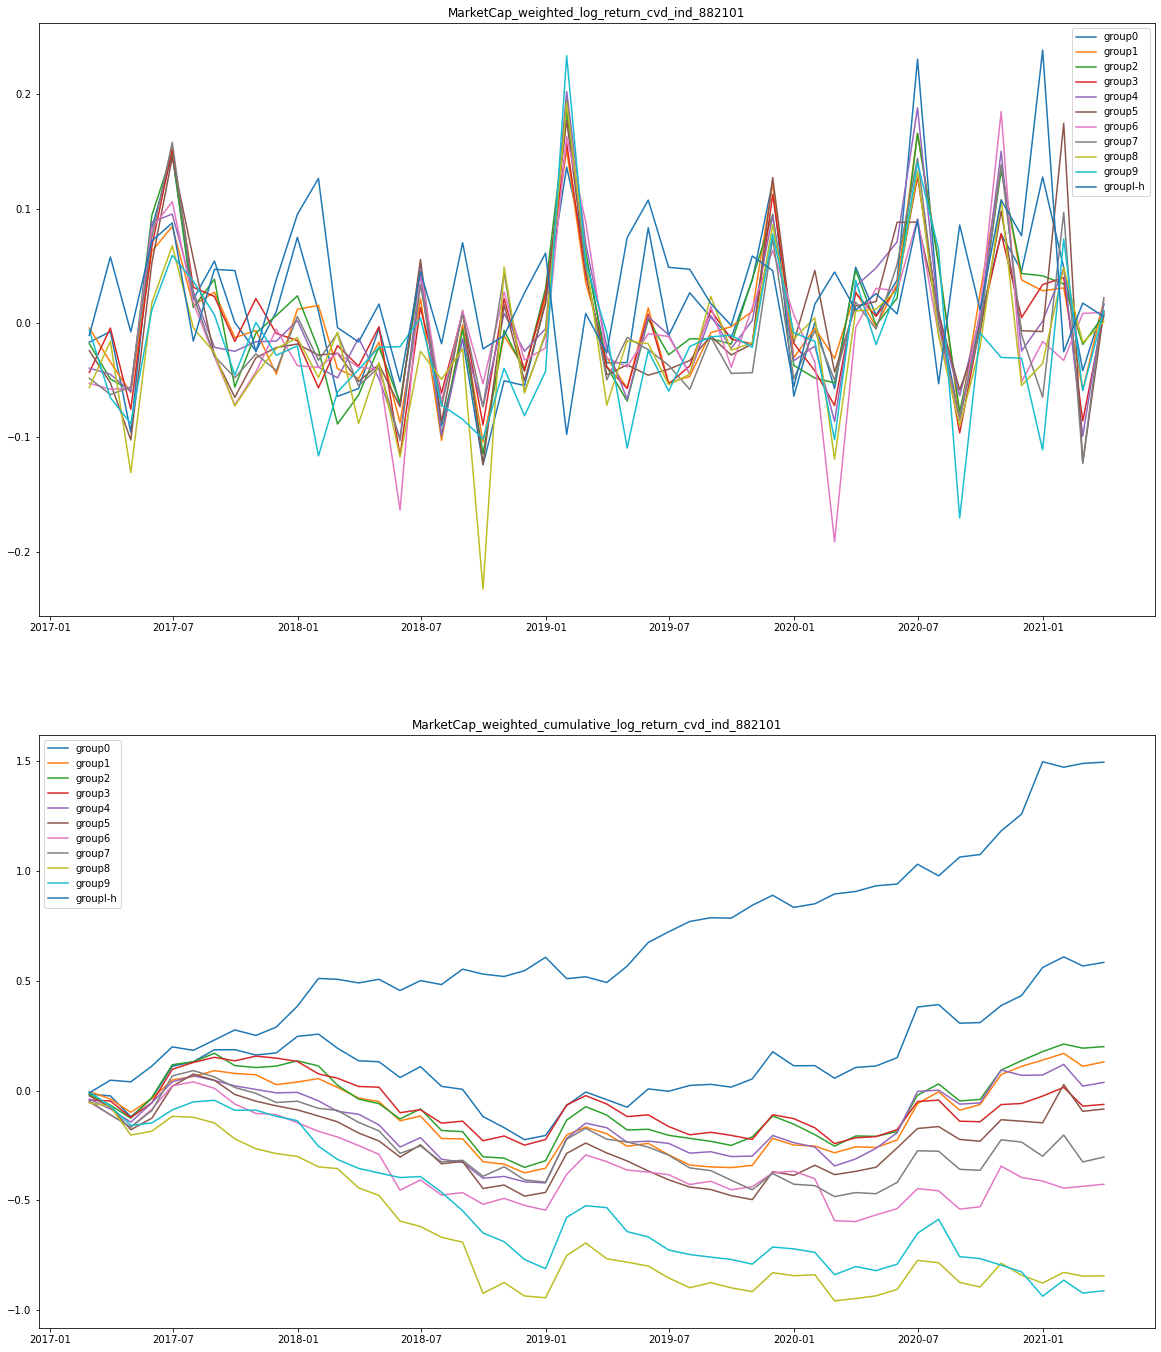

In [48]:
#882101市值加权
ind_882101_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882101')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.1116       -0.028 -0.702  [-0.0028, -0.3572]    [0.2033, 1.3064]   
1       -0.1396      -0.0355 -0.884  [-0.0033, -0.4279]    [0.1665, 1.0636]   
2       -0.1934      -0.0503 -0.992  [-0.0048, -0.5901]    [0.2476, 1.5209]   
3       -0.3369      -0.0939 -1.134  [-0.0086, -1.0039]    [0.2146, 1.2423]   
4       -0.3318      -0.0922 -1.172  [-0.0085, -0.9593]    [0.1989, 1.1243]   
5       -0.4073       -0.118 -1.383  [-0.0109, -1.2573]    [0.2273, 1.3053]   
6       -0.3699      -0.1049 -1.322   [-0.0096, -1.103]    [0.1956, 1.1174]   
7       -0.4902      -0.1493 -1.456  [-0.0138, -1.4917]    [0.1409, 0.7616]   
8         -0.44      -0.1299 -1.349   [-0.012, -1.2795]    [0.2049, 1.0884]   
9       -0.6722      -0.2348 -1.175  [-0.0228, -2.4252]    [0.2281, 1.2114]   
l-h      1.7098       0.2703  0.833      [0.02, 3.8925]  [-0.0248, -0.2411]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0006, 0.0744]    [0.0057, 0.6056]       0.406  
1      [0.0046, 0.5905]    [0.0083, 0.9595]       0.422  
2      [0.0042, 0.5337]     [0.007, 0.7793]       0.437  
3     [-0.0001, -0.006]    [0.0027, 0.2782]       0.488  
4    [-0.0005, -0.0575]     [0.0065, 0.682]        0.51  
5    [-0.0017, -0.1988]    [0.0043, 0.4616]       0.513  
6      [0.0003, 0.0409]    [0.0042, 0.4554]       0.503  
7     [-0.004, -0.4561]    [0.0026, 0.2696]       0.552  
8     [-0.0028, -0.314]    [0.0033, 0.3345]       0.544  
9     [-0.013, -1.3973]  [-0.0063, -0.6091]       0.693  
l-h    [0.0136, 2.8729]    [0.0119, 2.2734]       0.057

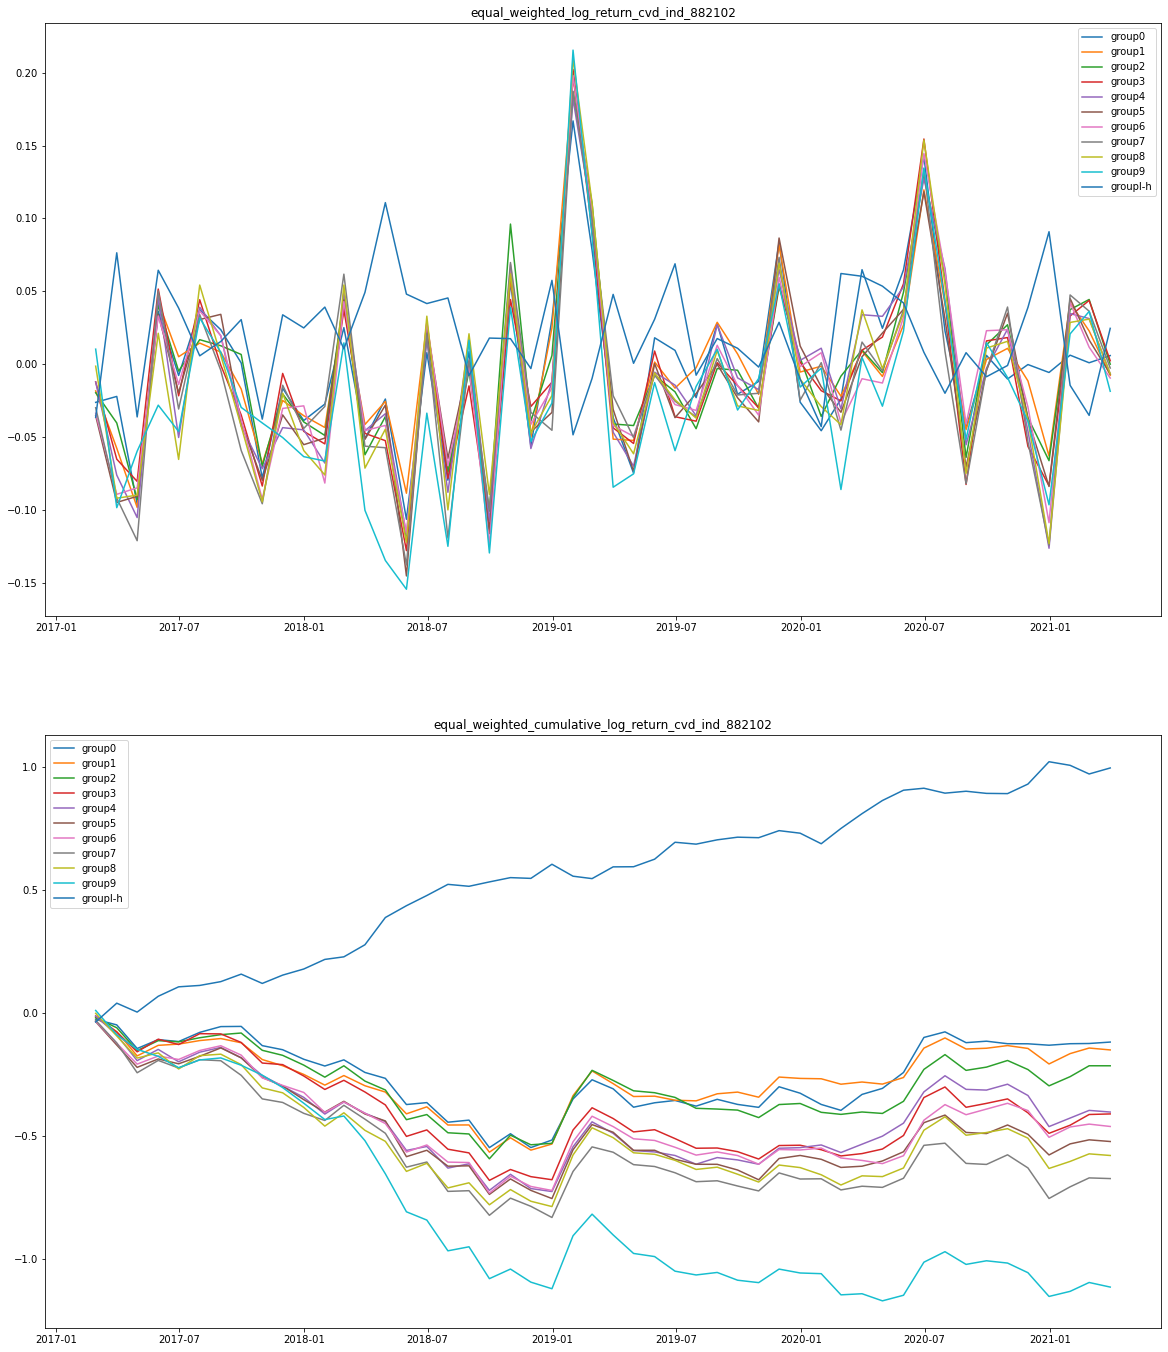

In [49]:
#882102等值加权
ind_882102_test.E_weight(ob_t = ob_t,tt='cvd_ind_882102')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0       -0.0174      -0.0042  -0.36  [-0.0007, -0.0777]    [0.1588, 0.9241]   
1        0.0197       0.0047  -0.38    [0.0002, 0.0214]    [0.1211, 0.8524]   
2       -0.1405      -0.0357 -0.905   [-0.0034, -0.526]    [0.1893, 1.4587]   
3       -0.4712      -0.1418 -1.215  [-0.0129, -1.7104]    [0.0637, 0.4217]   
4       -0.2643       -0.071 -1.126  [-0.0065, -0.7889]    [0.1681, 1.0212]   
5       -0.3193      -0.0882 -1.186  [-0.0079, -0.9909]    [0.1183, 0.7366]   
6       -0.3075      -0.0844 -1.134  [-0.0077, -0.9799]    [0.1949, 1.2299]   
7       -0.4195      -0.1224 -1.415  [-0.0112, -1.2858]    [0.1806, 1.0302]   
8       -0.4298      -0.1261 -1.299  [-0.0116, -1.2492]    [0.1816, 0.9752]   
9       -0.6887      -0.2443  -1.08  [-0.0239, -2.5268]    [0.2641, 1.3934]   
l-h      2.1567       0.3177  0.854    [0.0232, 3.2295]  [-0.1053, -0.7306]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0    [-0.0017, -0.1908]    [0.0054, 0.5395]        0.43  
1      [0.0049, 0.6651]    [0.0074, 0.9166]       0.331  
2       [0.003, 0.4504]    [0.0042, 0.5684]       0.355  
3     [-0.009, -1.1429]   [-0.0067, -0.767]       0.476  
4    [-0.0006, -0.0707]    [0.0061, 0.6571]       0.422  
5    [-0.0011, -0.1389]    [0.0033, 0.3596]        0.41  
6      [0.0017, 0.2209]    [0.0058, 0.6698]       0.419  
7    [-0.0041, -0.4614]    [0.0018, 0.1794]       0.509  
8    [-0.0042, -0.4458]    [0.0018, 0.1672]       0.531  
9     [-0.0145, -1.529]   [-0.008, -0.7743]       0.699  
l-h    [0.0127, 2.0141]    [0.0134, 1.8704]       0.132

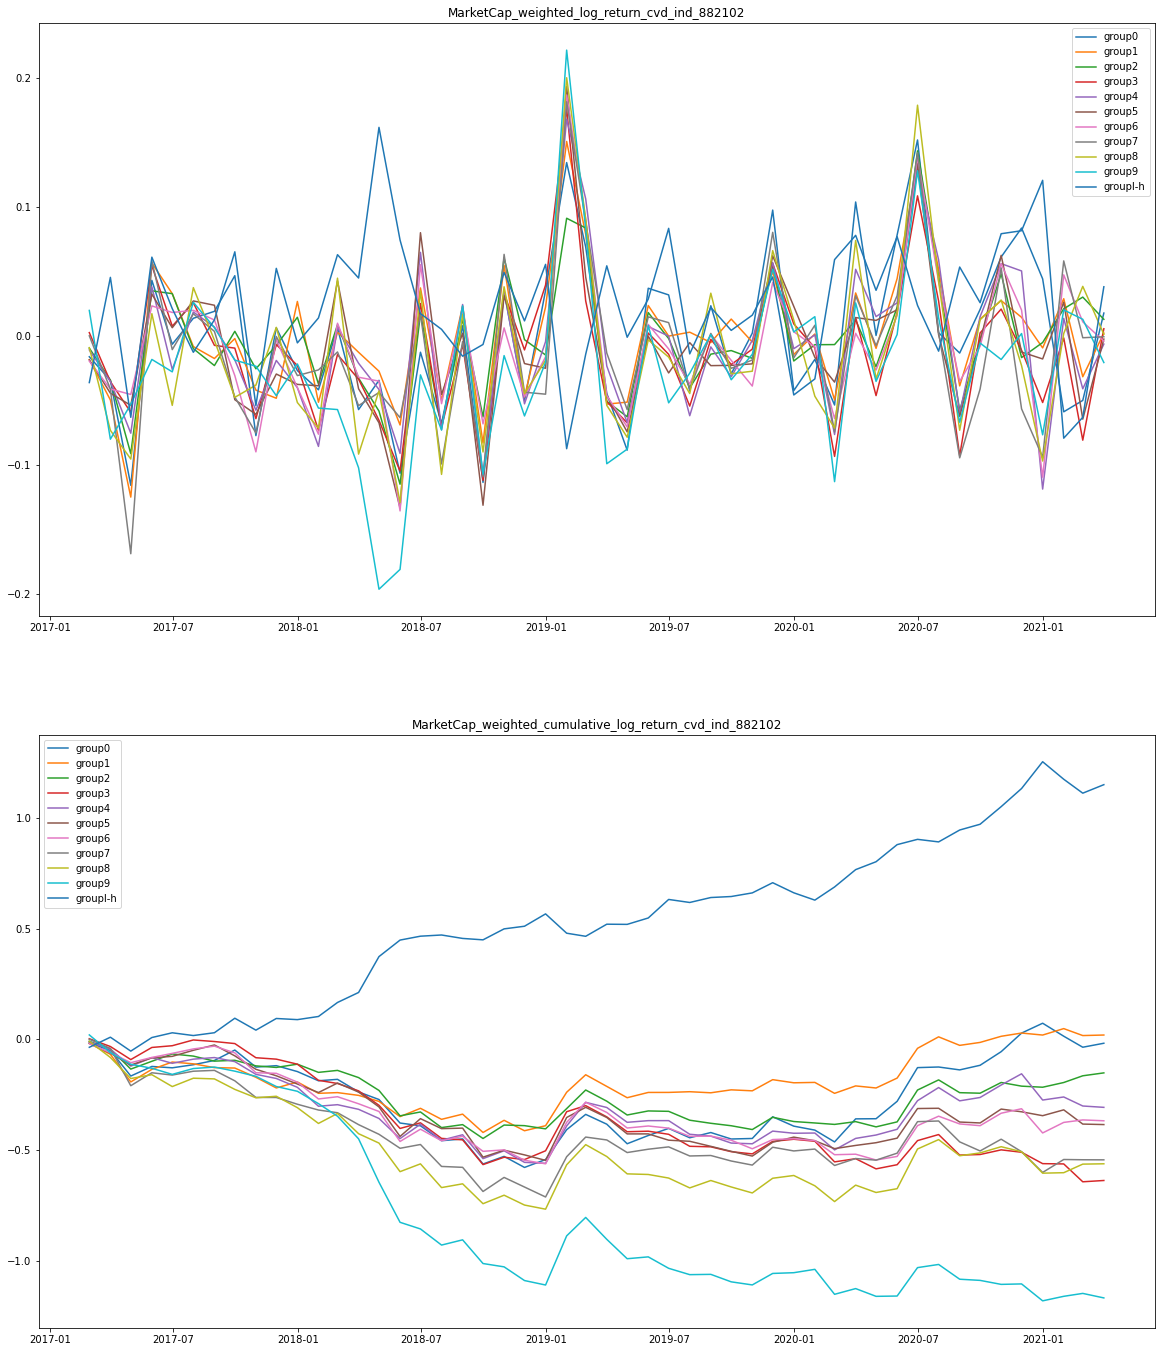

In [50]:
#882102市值加权
ind_882102_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882102')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0         0.297       0.0644  0.183    [0.0051, 0.4224]    [0.0659, 0.2736]   
1        -0.184      -0.0476  -0.85   [-0.004, -0.3969]  [-0.0106, -0.0516]   
2        0.0073       0.0018  -0.29   [-0.0005, -0.055]    [0.3308, 1.7866]   
3       -0.3053      -0.0837 -1.009   [-0.0074, -0.671]    [0.0561, 0.2536]   
4       -0.0955      -0.0238 -0.669  [-0.0021, -0.2046]    [0.0718, 0.3406]   
5       -0.3195      -0.0883  -1.22  [-0.0079, -0.8074]     [0.125, 0.6329]   
6        -0.435      -0.1281 -1.349  [-0.0116, -1.1031]    [0.0838, 0.3977]   
7       -0.2584      -0.0692 -1.469  [-0.0062, -0.5656]    [0.0963, 0.4397]   
8       -0.5267      -0.1643 -1.519  [-0.0151, -1.5511]    [0.0837, 0.4278]   
9       -0.6489      -0.2222 -1.478  [-0.0211, -1.8261]     [0.0779, 0.336]   
l-h      2.6944       0.3684   0.91    [0.0262, 2.6825]  [-0.0119, -0.0611]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0023, 0.1774]    [0.0084, 0.5895]       0.456  
1     [-0.001, -0.0931]     [0.005, 0.4234]       0.395  
2       [0.0051, 0.516]    [0.0157, 1.4657]       0.476  
3    [-0.0001, -0.0078]    [0.0078, 0.6504]       0.492  
4      [0.0065, 0.6254]     [0.0134, 1.157]       0.389  
5     [-0.001, -0.1032]    [0.0067, 0.6221]       0.505  
6     [-0.0021, -0.202]     [0.007, 0.6277]       0.543  
7       [0.004, 0.3932]     [0.014, 1.2968]        0.44  
8    [-0.0062, -0.6621]    [0.0019, 0.1828]       0.519  
9    [-0.0117, -1.0228]  [-0.0007, -0.0562]       0.643  
l-h    [0.0139, 1.6937]    [0.0091, 0.9984]       0.213

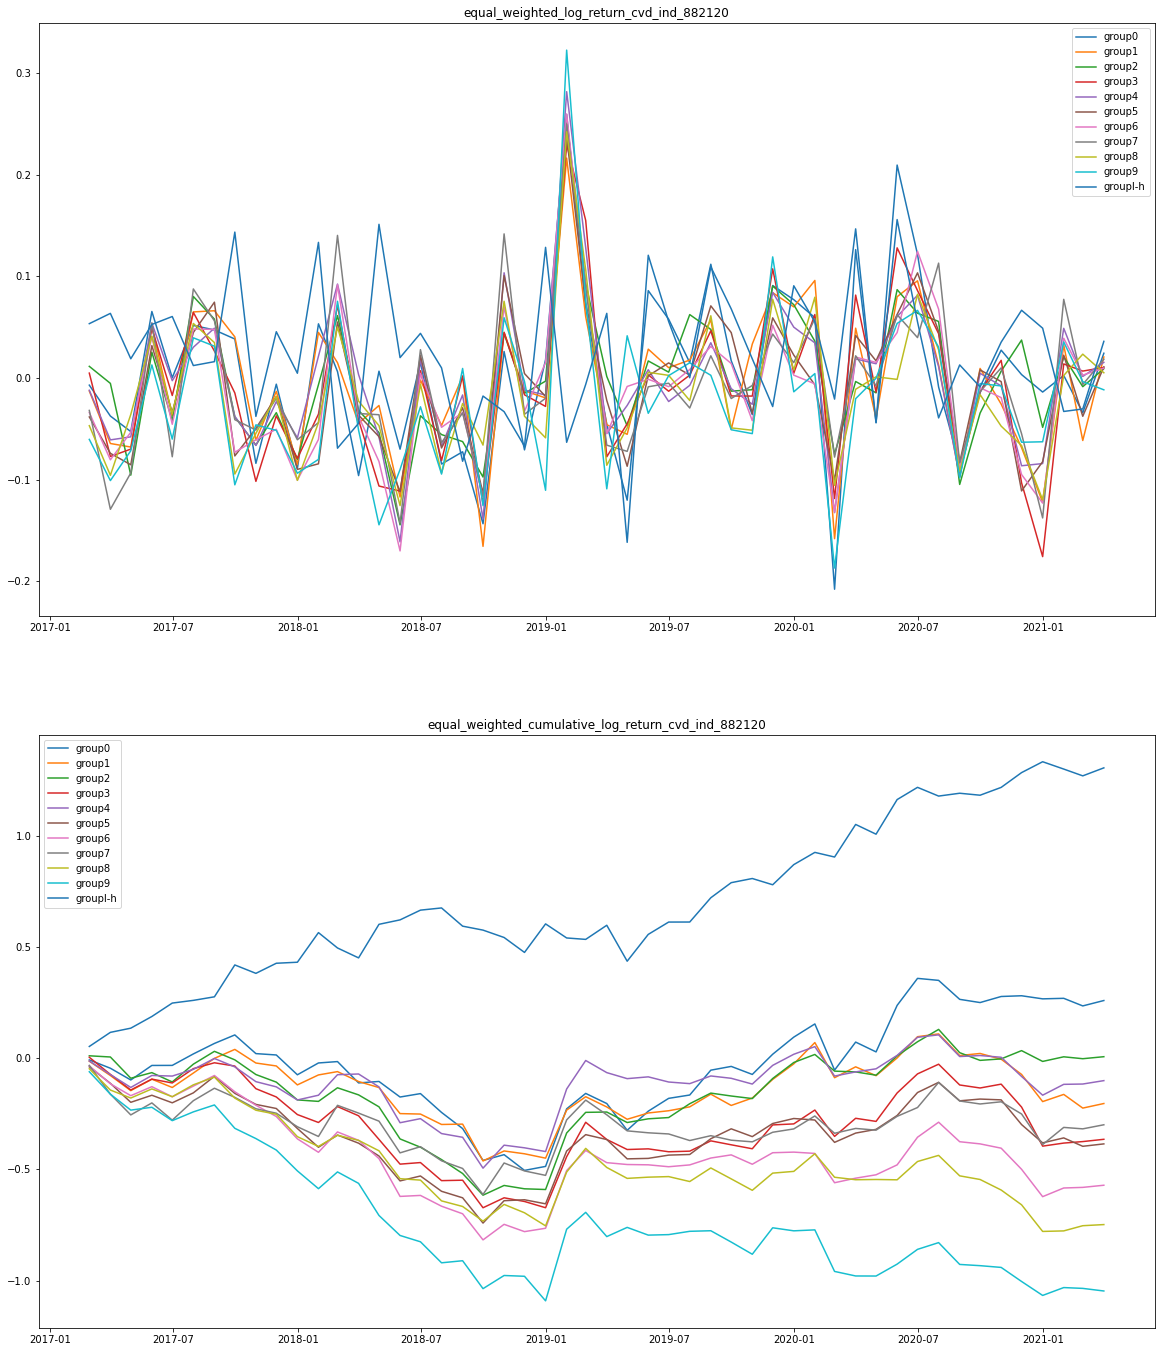

In [51]:
#882101等值加权
ind_882120_test.E_weight(ob_t = ob_t,tt='cvd_ind_882120')

TotalReturn AnnualReturn Sharpe          CAPM Alpha                Beta  \
0        0.8485       0.1589  0.506    [0.0118, 0.8588]     [0.238, 0.8617]   
1       -0.1697      -0.0437 -0.703  [-0.0036, -0.3317]   [-0.0412, -0.187]   
2        0.2616       0.0574  0.137    [0.0043, 0.3817]     [0.1972, 0.881]   
3       -0.2009      -0.0524 -0.936  [-0.0044, -0.4125]   [-0.0376, -0.175]   
4        0.1923       0.0431  0.047    [0.0036, 0.3079]  [-0.0188, -0.0811]   
5       -0.3527      -0.0991 -1.131   [-0.0089, -0.931]    [0.1053, 0.5485]   
6       -0.6012       -0.198  -1.09  [-0.0185, -1.2373]    [0.0451, 0.1504]   
7        -0.241       -0.064 -1.407  [-0.0057, -0.5336]     [0.0948, 0.442]   
8       -0.3589      -0.1012   -1.3   [-0.009, -0.8438]    [0.0316, 0.1486]   
9       -0.6786      -0.2385 -1.302  [-0.0228, -1.7632]    [0.0672, 0.2584]   
l-h      4.7515       0.5218  0.807    [0.0347, 2.4628]    [0.1708, 0.6048]   

    fama-3-factor alpha fama-5-factor alpha Maxdrawdown  
0      [0.0032, 0.2327]    [0.0075, 0.4809]       0.442  
1    [-0.0047, -0.4047]    [-0.001, -0.076]       0.464  
2      [0.0064, 0.5384]    [0.0163, 1.2401]       0.497  
3    [-0.0011, -0.1018]    [0.0013, 0.1062]       0.401  
4      [0.0075, 0.6102]     [0.0165, 1.223]        0.31  
5     [-0.0038, -0.382]    [0.0049, 0.4483]       0.522  
6    [-0.0083, -0.5403]    [0.0069, 0.4117]       0.662  
7      [0.0058, 0.5634]    [0.0118, 1.0532]       0.354  
8    [-0.0016, -0.1468]     [0.0084, 0.708]         0.4  
9     [-0.0127, -0.963]  [-0.0014, -0.0993]       0.673  
l-h    [0.0159, 1.3336]    [0.0089, 0.6737]       0.266

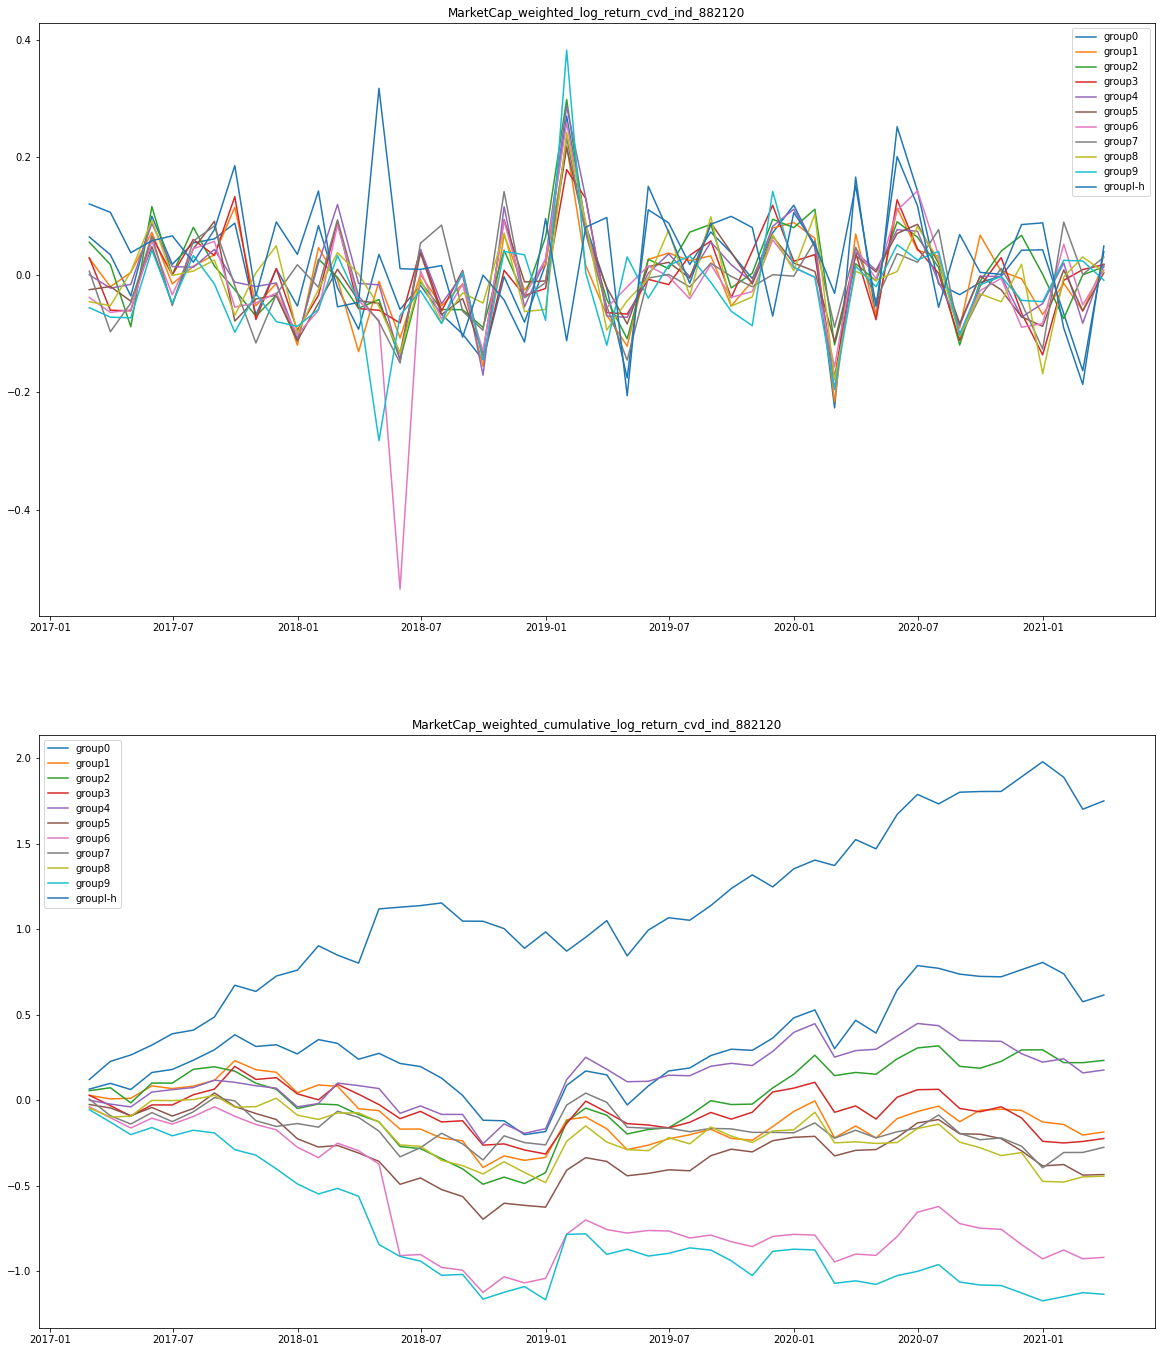

In [52]:
#882101市值加权
ind_882120_test.MC_weight(ob_t = ob_t,tt='cvd_ind_882120')

mean        0.135199
median     -0.093382
max         3.536109
min        -2.408190
std         1.105175
skewness    0.688062
kurtosis   -0.215127
dtype: float64


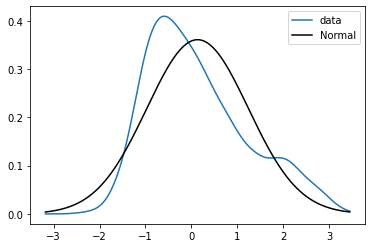

mean       -0.164438
median     -0.260966
max         2.916036
min        -2.830674
std         0.728064
skewness    0.598504
kurtosis    1.346955
dtype: float64


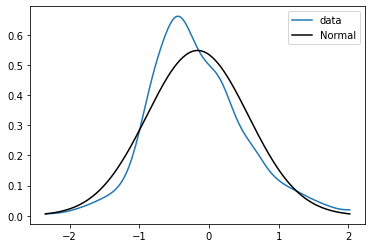

In [54]:
#回归分析的数据处理
#取log，同时对极端值进行处理，进行normalization
#cvd_latest=np.log(cvd_latest)
def normalization(data,ax=1):
    def centrilization(x):
        y=abs(x-x.median()).median()*5
        x[x>(x.median()+y)]=x.median()+y
        x[x<(x.median()-y)]=x.median()-y
        return(x)
    data=data.apply(centrilization,axis=ax)
    data=data.apply(lambda x: (x-x.mean())/x.std(),axis=ax)
    return(data)
cvd_norm = normalization(cvd_latest,ax=0)
Re_norm = normalization(Re_latest,ax=0)
statistics(cvd_norm.iloc[0,:])
statistics(Re_norm.iloc[0,:])

mean        -1.194452
mean(abs)    2.740123
std          3.324203
|t|>2        0.540000
dtype: float64


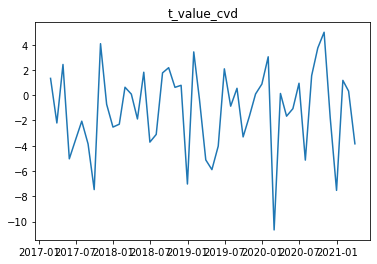

In [55]:
t_value = []
ob_t = Re.index[-51:-1]
for i in ob_t:
    X = np.mat(np.stack([np.ones(shape=cvd_norm.loc[i,:].shape),cvd_norm.loc[i,:]]).T)
    y = np.mat(Re_norm.loc[i,:].to_numpy()).T
    beta = (X.T*X).I*X.T*y
    u = y-X*beta

    #estimated variation of regression
    varbeta = (u.T*u)[0,0]/(len(y)-len(beta))*(X.T*X).I
    se = np.sqrt(np.diag(varbeta))

    #record estimation
    t_value.append((beta.T/se)[0,1])
t_value = pd.Series(t_value,index = ob_t)
plt.plot(t_value)
plt.title('t_value_cvd')
print(pd.Series({'mean':np. mean(t_value),'mean(abs)':np.mean(abs(t_value)),'std':np.std(t_value),'|t|>2':t_value[abs(t_value)>2].count()/t_value.count()}))        

TypeError: must be real number, not str

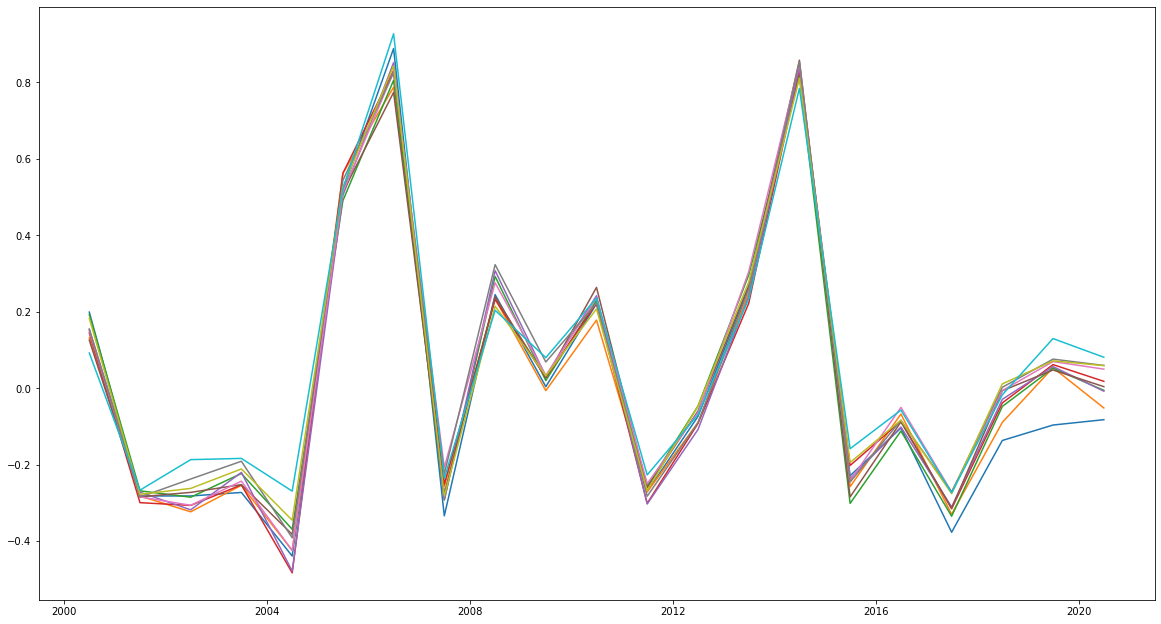

In [322]:
ew_re = pd.DataFrame(None,index=COP.index,columns=list(range(10)))
for i in COP.index:
    selected = Re.loc[i,:].dropna().index
    groups = pd.qcut(COP.loc[i,selected],10,labels=list(range(10)))
    ew_re.loc[i,:] = Re.loc[i,groups.index].groupby(by=groups).mean()

#多空组合
ew_re['l-h'] = ew_re[0]-ew_re[9]
        
#cumulative return
ew_re_cum = ew_re.cumsum()

#plot
plt.figure(figsize=(20,24))
plt.subplot(211)
for i in ew_re.columns:
    plt.plot(ew_re[i],label='group'+str(i))
plt.title('equal_weighted_log_return_'+tt)
plt.legend()

TypeError: must be real number, not str

In [372]:
mw_re = pd.DataFrame(None,index=COP.index,columns=list(range(10)))

#收益率乘以市值再分组加总后，除以各组市值加总即为各组市值加权平均收益，这一方法在迭代上具有优势
mw = Re*MC

for i in COP.index:
    selected = Re.loc[i,:].dropna().index
    groups = pd.qcut(COP.loc[i,selected],10,labels=list(range(10)))
    mw_re.loc[i,:] = mw.loc[i,groups.index].groupby(by=groups).sum()/MC.loc[i,groups.index].groupby(by=groups).sum()

#多空组合
mw_re['h-l'] = mw_re[9]-mw_re[0]
        
#cumulative return
mw_re_cum = mw_re.cumsum()


In [373]:
mw_re

0          1          2           3          4  \
2000-06-30  0.0427453  0.0516134  0.0998734   0.0281407  0.0635889   
2001-06-30   -0.28976  -0.308569  -0.254251   -0.280568  -0.256325   
2002-06-30  -0.266802  -0.287695  -0.287338   -0.274438   -0.24146   
2003-06-30  -0.299405  -0.205474  -0.169853   -0.214563  -0.158475   
2004-06-30  -0.314295  -0.308376  -0.310457   -0.452371   -0.46922   
2005-06-30    0.47363   0.458855   0.513513    0.611654   0.404463   
2006-06-30   0.982739   0.839106   0.938864     0.97777   0.909428   
2007-06-30  -0.428611  -0.392709  -0.374379    -0.37614   -0.42325   
2008-06-30   0.119924   0.131467    0.21315     0.12578   0.221403   
2009-06-30  -0.164862  -0.199551  -0.138103    -0.14352  -0.157634   
2010-06-30   0.217871   0.151047   0.212457     0.20858    0.18004   
2011-06-30  -0.261413  -0.294027  -0.258272   -0.244717  -0.221552   
2012-06-30  -0.152026  -0.176253  -0.150841   -0.135696  -0.197798   
2013-06-30   0.130595  0.0769446  0.0930593   0.0446599  0.0959296   
2014-06-30   0.749312   0.824635   0.744971    0.584187   0.765152   
2015-06-30  -0.424633   -0.42198  -0.481433   -0.300636  -0.375042   
2016-06-30  0.0449727   0.101623  -0.030394   0.0519065   0.126625   
2017-06-30  -0.303145  -0.125512 -0.0725324   -0.159111   -0.16761   
2018-06-30 -0.0795641  0.0795721  0.0137612  -0.0619777 -0.0945044   
2019-06-30   -0.10081 -0.0695292 -0.0852682  0.00711257  0.0282043   
2020-06-30  0.0297451   0.031057   0.073121    0.128686  0.0965146   

                     5          6           7          8          9        h-l  
2000-06-30   0.0569157  0.0145925   0.0724075   0.110011  0.0210652   -0.02168  
2001-06-30   -0.240332  -0.252226   -0.268418  -0.249014  -0.355763  -0.066003  
2002-06-30   -0.241606  -0.290776    -0.15959  -0.233812  -0.156857   0.109945  
2003-06-30   -0.191046  -0.214249   -0.169673  -0.215409  -0.181268   0.118138  
2004-06-30   -0.291604  -0.391762   -0.343105  -0.305322  -0.229726  0.0845688  
2005-06-30    0.502445   0.524205    0.433371    0.46561   0.466455 -0.0071753  
2006-06-30    0.792449   0.841417    0.840555   0.895295   0.908043 -0.0746956  
2007-06-30   -0.413668  -0.155449   -0.314179  -0.310031  -0.241012   0.187598  
2008-06-30  0.00283386   0.102649     0.20848   0.112835  0.0956403 -0.0242838  
2009-06-30    -0.11537  -0.138795    -0.16974  -0.173483 -0.0241622     0.1407  
2010-06-30    0.135733   0.212945    0.105322   0.137176   0.105663  -0.112208  
2011-06-30   -0.246151  -0.239546   -0.197088  -0.204583   -0.17937  0.0820431  
2012-06-30   -0.116162   -0.14132   -0.148793  -0.144359 -0.0402475   0.111778  
2013-06-30   0.0622175    0.16558   0.0519941    0.12043  -0.025613  -0.156208  
2014-06-30     0.79638   0.770069    0.774722    0.65244   0.605113  -0.144198  
2015-06-30   -0.334305  -0.395962   -0.315643  -0.306379  -0.261054    0.16358  
2016-06-30    0.028459  0.0341171 -0.00484962   0.016532 -0.0436726 -0.0886453  
2017-06-30   -0.169093 -0.0243705   -0.195608  -0.199233   -0.18823   0.114915  
2018-06-30   0.0120454   0.117472   0.0817764 -0.0169489 -0.0109183  0.0686458  
2019-06-30   0.0282797   0.103226    0.120994   0.075814   0.226707   0.327517  
2020-06-30    0.213707   0.129598   0.0658043   0.150085   0.122074  0.0923286